### Unit 2: Lesson 5: Unit 2: Lesson 4: Project 4 Challenge: Multivariable Regression: 2013 New York Crime
#### Objectives: Clean and Prepare Data, Create an OLS Model to Predict Property Crime and evaluate and iterate the model
Saheed Tijani

Dec 31, 2018

##### NOTE: This solution builds on the initial data preparation assignment in Unit2_Lesson4_drill1 and Unit 2: Lesson 4: Unit 2: Lesson 4: Project 4 Challenge: Multivariable Regression: 2013 New York Crimesubmitted via: 
https://github.com/datafrick/Thinkful_desk/blob/master/unit2_lesson4_drill1.ipynb
https://github.com/datafrick/Thinkful_desk/blob/master/unit2-lesson4-drill4-challenge-multivariable-regression-new-york-crime-predict-property-crimes.ipynb


In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler
import math
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import scipy
from scipy import stats
from scipy.stats import boxcox
from statsmodels.sandbox.regression.predstd import wls_prediction_std
sns.set_style('white')
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")


In [2]:
#grab the raw data
data_raw = pd.read_csv('table_8_offenses_known_to_law_enforcement_new_york_by_city_2013_csv.csv', header=None)

#below line was used to clean up the 2014 data
#data_raw = pd.read_csv('table_8_offenses_known_to_law_Enforcement_by_new_york_by_city_2014_csv.csv', header=None)

#### Data cleaning

In [3]:
#remove data rows(0,1,2 and 3), and the last 3 rows. This row are only describe the data. They do not have statistical values.
#drop the rape1 col as well as it has not observation.
data_cleaning = data_raw.drop(data_raw.index[:5]).drop(data_raw.index[-3:])

#name data columns
data_cleaning.columns = ['city', 'population', 'violent_crime', 'murder_manslaughter',
       'rape_1', 'rape_2', 'robbery', 'aggravated_assault', 'property_crime', 
       'burglary', 'larceny_theft', 'mv_theft', 'arson_3']

#drop the rape1 col as it has no observation.
data_cleaning = data_cleaning.drop('rape_1', axis=1)

# Remove commas in numbers in relevant cols
data_cleaning['population'] = data_cleaning['population'].str.replace(',', '')
data_cleaning['robbery'] = data_cleaning['robbery'].str.replace(',', '')

#data is now clean and ready for feature engineering, let's name the clean data
data_cleaned = data_cleaning

#overview overview of clean data
data_cleaned.head()

,city,population,violent_crime,murder_manslaughter,rape_2,robbery,aggravated_assault,property_crime,burglary,larceny_theft,mv_theft,arson_3
5,Adams Village,1861,0,0,0,0,0,12,2,10,0,0
6,Addison Town and Village,2577,3,0,0,0,3,24,3,20,1,0
7,Akron Village,2846,3,0,0,0,3,16,1,15,0,0
8,Albany,97956,791,8,30,227,526,"4,090",705,"3,243",142,NaN
9,Albion Village,6388,23,0,3,4,16,223,53,165,5,NaN


### Creating Features

In [4]:
#create the population-square feature
data_cleaned['population_square'] =  (data_cleaned['population']).astype(int)**2

#create a function to categrize continous data
def cont_2_cat(col):
    for element in col:
        if int(element) > 1:
            return 1
        else:
            return 0
#apply our cont_2_cat function to catgorize data_cleaned.murder_manslaughter and create feature with the result       
data_cleaned['murder_manslaughter_categorical'] = data_cleaned.murder_manslaughter.apply(cont_2_cat)

#use the npwhere method to categorize roberry and create a feature with it
#I could'nt figure out why - feature_data['robbery_categorical'] = np.where(int(data_cleaned['robbery']) > 1 ,1,0) did not work
data_cleaned['robbery_categorical'] = np.where((data_cleaned['robbery']).astype(int) > 1 ,1,0)

#final data overview
data_cleaned

,city,population,violent_crime,murder_manslaughter,rape_2,robbery,aggravated_assault,property_crime,burglary,larceny_theft,mv_theft,arson_3,population_square,murder_manslaughter_categorical,robbery_categorical
5,Adams Village,1861,0,0,0,0,0,12,2,10,0,0,3463321,0,0
6,Addison Town and Village,2577,3,0,0,0,3,24,3,20,1,0,6640929,0,0
7,Akron Village,2846,3,0,0,0,3,16,1,15,0,0,8099716,0,0
8,Albany,97956,791,8,30,227,526,"4,090",705,"3,243",142,NaN,1005443344,1,1
9,Albion Village,6388,23,0,3,4,16,223,53,165,5,NaN,40806544,0,1
10,Alfred Village,4089,5,0,0,3,2,46,10,36,0,NaN,16719921,0,1
11,Allegany Village,1781,3,0,0,0,3,10,0,10,0,0,3171961,0,0
12,Amherst Town,118296,107,1,7,31,68,"2,118",204,"1,882",32,3,1109041728,0,1
13,Amityville Village,9519,9,0,2,4,3,210,16,188,6,1,90611361,0,1
14,Amsterdam,18182,30,0,0,12,18,405,99,291,15,0,330585124,0,1


#### The Modellimg Part starts from here

##### Criteria for selecting independent variables;
1. Independent variable must not be closely correlated
2. Indenpent variables should share a linear relationship (as close as possible) with the outcome variable
3. Each variable on it's own must be close to ideal normal distribution as possible

We will now examine our indepepent variables and select those to be included in our model based on the above criteria

##### Further data cleaning

In [5]:
#first let's slice out only the numerical columns of the data to enable analysis
data_cleaned_num = data_cleaned.loc[:, 'population': ]

#next remove comma and convert all the values to int
col = data_cleaned_num.columns.tolist()
for element in col:
    data_cleaned_num[element] = data_cleaned_num[element].astype(str).str.replace(',','').replace('nan', 0).astype(int)

##### Feature Engineering

Generate correlation matrix and plot heat map:


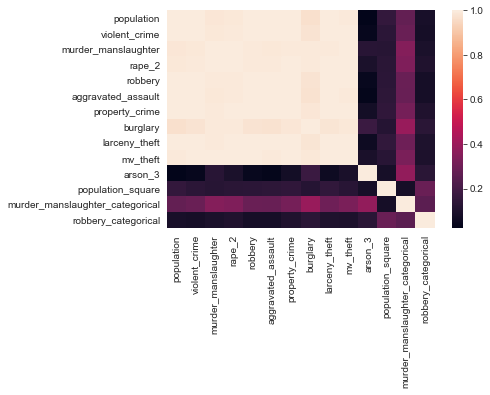

In [6]:
#Checking for correllation through correlation matrix and heat map diagram
print('Generate correlation matrix and plot heat map:')
data_cleaned_num.corr()
sns.heatmap(data_cleaned_num.corr())

##### Addrissing variable correllation:
As can be seen above, we have strong **correllation** between: **population**, **violent_crime**, **Murder_manslaughter**, **rape_2**, **robbery**, **aggravated_assault**, **property_crime**, **burglary**, **larceny_theft** and **mv_theft**. Since a feature (population_square) has initially been created from population, population as a variable will hence forthbe dropped. The remaining 8 correlating features will then be scaled and combined as a single feature.

In [7]:
#drop the populaton col
data_cleaned_num.drop('population', axis=1, inplace=True)

scaler = MinMaxScaler() #imported from sklearn.preprocessing
data_cleaned_num = pd.DataFrame(scaler.fit_transform(data_cleaned_num), columns=data_cleaned_num.columns)

#let's now create a single feature using the mean of all the 8 correllated variables 
# create the column names for the correllated variables
cor_var_col = col[1:6] + col[7:10]

#create the correllatd variables dataframe
cor_var = pd.DataFrame()
cor_var[cor_var_col] = data_cleaned_num[cor_var_col]

data_cleaned_num['cor_var_feature'] = cor_var[cor_var_col].mean(axis=1)

#will now drop all the correllated variables from our data since they have all be represented by a single feature(cor_var)
data_cleaned_num.drop(cor_var_col, axis=1, inplace=True)

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


##### Let's do a pair plot of our features and outcome variable to see the what they look like.

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


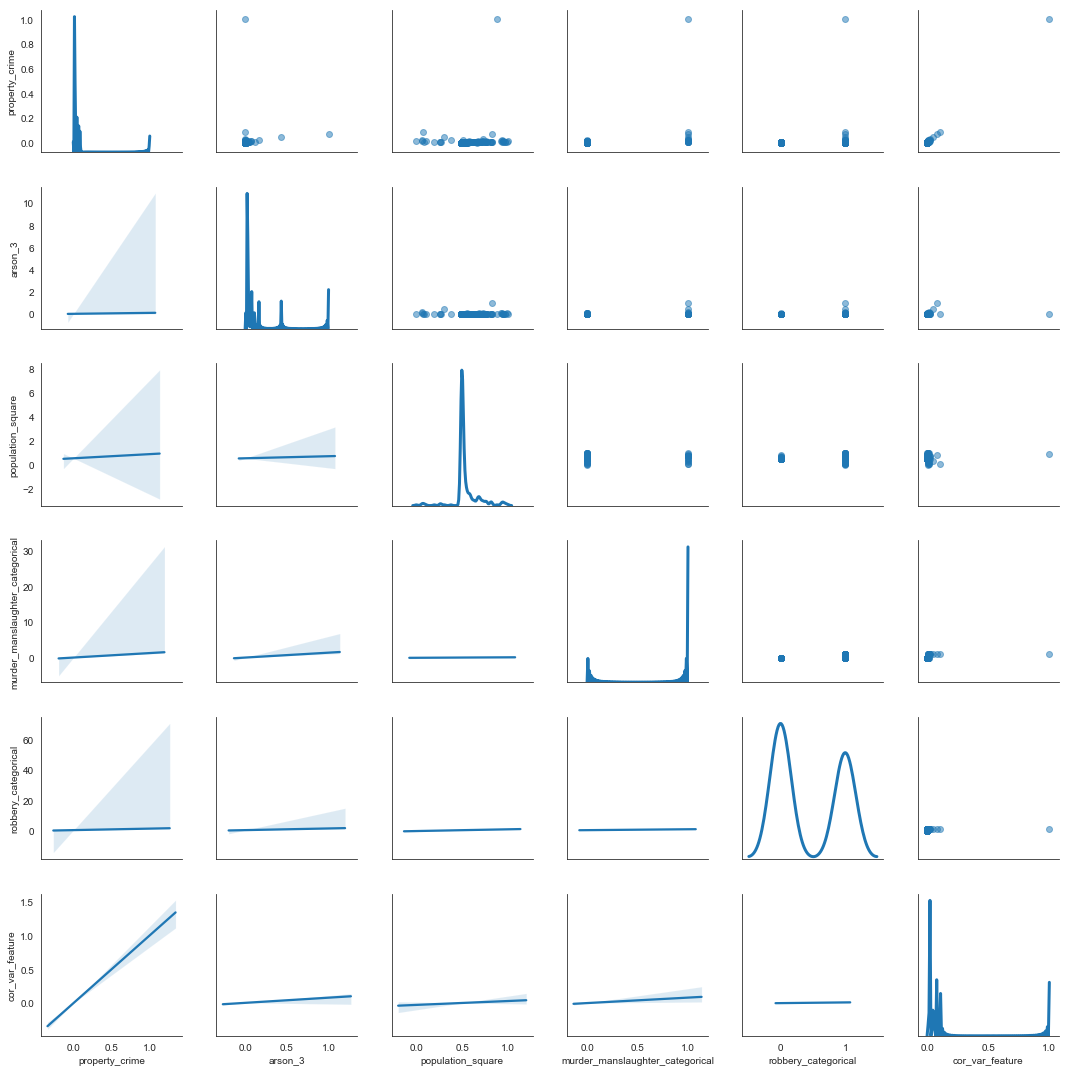

In [8]:
g = sns.PairGrid(data_cleaned_num.dropna(how = 'any', axis = 0), diag_sharey=False)

#Scatterplot.
g.map_upper(plt.scatter, alpha=.5)

#Fit line summarizing the linear relationship of the two variables.
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))

#Give information about the univariate distributions of the variables.
g.map_diag(sns.kdeplot, lw=3)
plt.show()

##### Now we have five independent variables made up of purely features(manipulation of the independent variables). We will check them again for correllation.

Generate correlation matrix and plot heat map:


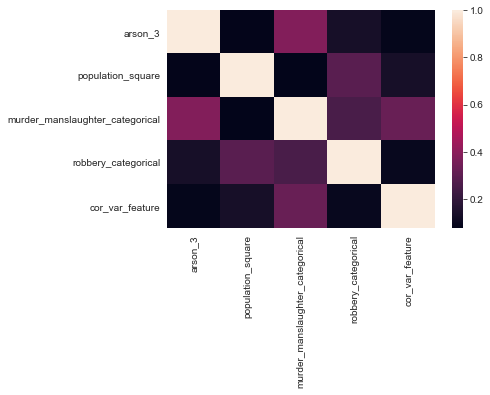

In [9]:
#let's re-draw our heatmap

#Checking for correllation through correlation matrix and heat map diagram
print('Generate correlation matrix and plot heat map:')
data_cleaned_num.drop('property_crime', axis=1).corr()
sns.heatmap(data_cleaned_num.drop('property_crime', axis=1).corr())

##### As we can see from the heatmap, these features are largely independent. We are now ready to run our OLS model

In [10]:
#run model using statsmodels.formula.api imported as smf 
lm_1 = smf.ols(formula = "property_crime ~ arson_3 + population_square + murder_manslaughter_categorical + robbery_categorical + cor_var_feature", data = data_cleaned_num).fit()
               
#generate model's summary
lm_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         property_crime   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 7.185e+04
Date:                Mon, 31 Dec 2018   Prob (F-statistic):               0.00
Time:                        22:36:47   Log-Likelihood:                 1733.4
No. Observations:                 348   AIC:                            -3455.
Df Residuals:                     342   BIC:                            -3432.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -0.0022      0.000     -5.434      0.000      -0.003      -0.001
arson_3                            -0.0057      0.002     -3.478      0.001      -0.009      -0.002
population_square                   0.0048      0.001      6.371      0.000       0.003       0.006
murder_manslaughter_categorical    -0.0024      0.000     -4.965      0.000      -0.003      -0.001
robbery_categorical                 0.0011      0.000      5.664      0.000       0.001       0.001
cor_var_feature                     0.9979      0.002    563.261      0.000       0.994       1.001
==============================================================================
Omnibus:                      173.018   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15004.554
Skew:                          -1.104   Prob(JB):                         0.00
Kurtosis:                      35.092   Cond. No.                         24.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### Plot the residual error to see how evenly distributed the errors are

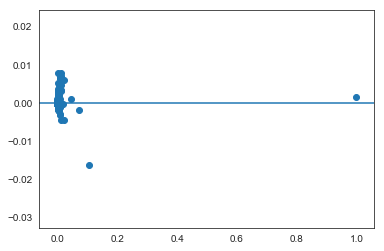

In [11]:
# Residual Error Plot
resid_1 = lm_1.resid
plt.axhline(y=0)
plt.scatter(lm_1.predict(), resid_1);

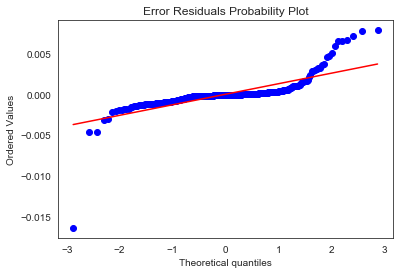

In [12]:
# Probability Plot to view normality (blue data should fit to red line of expected error)
stats.probplot(lm_1.resid, plot= plt)
plt.title("Error Residuals Probability Plot");

##### Rerun the model using the sklearn linear model rather than the stats model as per above

In [13]:
# Instantiate the model.
lin_regr = linear_model.LinearRegression()

# Fit model to data.
y_residual = data_cleaned_num['property_crime']
x_residual = data_cleaned_num[['arson_3', 'population_square', 'murder_manslaughter_categorical', 'robbery_categorical', 'cor_var_feature']]

lin_regr.fit(x_residual, y_residual)

# Extract predicted and actual values.
predicted = lin_regr.predict(x_residual).ravel()
actual = data_cleaned_num['property_crime']

# Calculate the error, also called the residual.
residual = actual - predicted

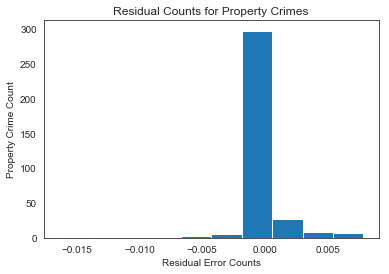

In [14]:

# Residual Error Plot
plt.hist(residual)
plt.title('Residual Counts for Property Crimes')
plt.xlabel('Residual Error Counts')
plt.ylabel('Property Crime Count')
plt.show()

## Evaluating Linear Regression Models 
The segments that follow evalute the model we have build. Here in the evaluation we are goint to use our `statsmodel` - lm_1 rather than the scikit-learn one.

##### Let's look at the parameters of our model

In [15]:
lm_1.params

Intercept                         -0.002
arson_3                           -0.006
population_square                  0.005
murder_manslaughter_categorical   -0.002
robbery_categorical                0.001
cor_var_feature                    0.998
dtype: float64

**We will now examine the** `p-values` **for each** `variables` **as a test of the significance in the** `outcome`

In [16]:
lm_1.pvalues

Intercept                         0.000
arson_3                           0.001
population_square                 0.000
murder_manslaughter_categorical   0.000
robbery_categorical               0.000
cor_var_feature                   0.000
dtype: float64

**Calculate** $R^2$

In [17]:
lm_1.rsquared

0.9990489247778102

**Generate confidence interval**

In [18]:
lm_1.conf_int()

,0,1
Intercept,-0.003,-0.001
arson_3,-0.009,-0.002
population_square,0.003,0.006
murder_manslaughter_categorical,-0.003,-0.001
robbery_categorical,0.001,0.001
cor_var_feature,0.994,1.001


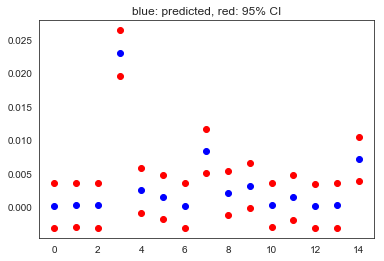

In [19]:
# Use wls_prediction_std to build confidence intervals
prstd, iv_l, iv_u = wls_prediction_std(lm_1)

plt.figure()
plt.plot(iv_u[0:15], 'o', color='r')
plt.plot(iv_l[0:15], 'o', color='r')
plt.plot(lm_1.fittedvalues[0:15], 'o', color='b')
plt.title('blue: predicted, red: 95% CI')
plt.show()

Our model seems to be doing fine considering themetrics above. First non of the parameters(i.e coefficients is zero), also all our p-values are less than the 0.05 treshold - this means all of our variables are contributing to the overall variance explained by the outcome. Also our R-square falls between 0-1 and our confidence interval does not contain 0 for any feature. The confidence intervals also seem to have good precision.

**Ask Mentor:**
* Is it normal that most of the `p-values` are zero?<br>
* Are these parameter values normal?<br>
* Should the `R-squared` value be this close to 1?<br>
* The confidence interval for **roberry_categorical** does not seem right, does it?
* Any comment of the `wls_prediction_std` confidence interval plot?


## Test model with Holdout(30% and 50%) and Leave-One-Out Cross Validation

##### Testing Model 30% with Holdout  

In [20]:
#import train_test_split
from sklearn.model_selection import train_test_split

#Split data into variable and outcome sets.
y_residual = data_cleaned_num['property_crime']
x_residual = data_cleaned_num[['arson_3', 'population_square', 'murder_manslaughter_categorical', 'robbery_categorical', 'cor_var_feature']]

#split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(x_residual, y_residual, test_size=0.3, random_state=20)

#fit the training and test data into model
lin_regr.fit(X_train, y_train).score(X_test, y_test)

#output the model coefficients and intercept
print('\nCoefficients: \n', lin_regr.coef_)
print('\nIntercept: \n', lin_regr.intercept_)

#output model's rsquared
print('\nR-squared:')
print(lin_regr.score(X_test, y_test))


Coefficients: 
 [3.53486772e-03 1.19830769e-03 3.20670199e-04 1.49769701e-03
 8.28857912e-01]

Intercept: 
 -0.0003157224927106657

R-squared:
0.9709619192856777


**COMMENT**: as can be seen from the result, our model's score(rsquared) improved from `0.999` to `0.9701` with holdout of `30%`. Our coefficients and intercepts are also quite significant. Let's now try `50%`.

##### Testing Model `50%` with Holdout 

In [21]:
#split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(x_residual, y_residual, test_size=0.5, random_state=20)

#fit the training and test data into model
lin_regr.fit(X_train, y_train).score(X_test, y_test)

#output the model coefficients and intercept
print('\nCoefficients: \n', lin_regr.coef_)
print('\nIntercept: \n', lin_regr.intercept_)

#output model's rsquared
print('\nR-squared:')
print(lin_regr.score(X_test, y_test))


Coefficients: 
 [0.00383327 0.00154867 0.00130542 0.00155461 0.81235377]

Intercept: 
 -0.0004815787365781347

R-squared:
0.9655605347297943


**Comment:** as can be seen from the result, our model's score(rsquared) improved from **0.9656** with holdout of 30%. Our coefficients and intercepts also remain significant. Let's now try `cross validation`with `100` groups

##### Testing Model with Out Cross-validation - 100 groups

In [22]:
#for this test I will use the function I coded earlier for this purpose with some little adjustment

def cross_val(data_variables, target_splits, k):
    #split the data and target df into k np arrays
    data_splits = np.array_split(data_variables, k)
    target_splits = np.array_split(target_splits, k)
    
    intercept = []
    coefi = []
    coefi_1 = []
    coefi_2 = []
    coefi_3 = []
    coefi_4 = []
    coefi_5 = []
    rsquared = []
    #train the model with each ith holdout and test with each (i+1)th holdout and compute the scores
    for i in range(k-1):
        #fit the training and test data into model
        lin_regr.fit(data_splits[i], target_splits[i]).score(data_splits[i+1], target_splits[i+1])
        
        #calculation models's intercept
        intercept.append(lin_regr.intercept_)
        
        #calculate model's rsquared
        rsquared.append(lin_regr.score(data_splits[i+1], target_splits[i+1]))
        
        #calculation models's coeficient and append each to the assigned array
        coefi.append(lin_regr.coef_)
        coefi_1.append(coefi[0][0])
        coefi_2.append(coefi[0][1])
        coefi_3.append(coefi[0][2])
        coefi_4.append(coefi[0][3])
        coefi_5.append(coefi[0][4])
        coefi = [] #reset array so it will always have 1 column
        
    print('max, min and mean of intercept are: {}, {}, {}'.format(max(intercept), min(intercept), np.mean(intercept)))
    print('max, min and mean of rsquared are: {}, {}, {}'.format(max(rsquared), min(rsquared), np.mean(rsquared)))
    print('max, min and mean of coefficient of variable1 is: {}, {}, {}'.format(max(coefi_1), min(coefi_1), np.mean(coefi_1)))
    print('max, min and mean of coefficient of variable2 is: {}, {}, {}'.format(max(coefi_2), min(coefi_2), np.mean(coefi_2)))
    print('max, min and mean of coefficient of variable3 is: {}, {}, {}'.format(max(coefi_3), min(coefi_3), np.mean(coefi_3)))
    print('max, min and mean of coefficient of variable1 is: {}, {}, {}'.format(max(coefi_4), min(coefi_4), np.mean(coefi_4)))
    print('max, min and mean of coefficient of variable1 is: {}, {}, {}'.format(max(coefi_5), min(coefi_5), np.mean(coefi_5)))
          
#call the function on ou spam example
cross_val(x_residual, y_residual, 100)



max, min and mean of intercept are: 0.19865035365096453, -0.4447092451842734, -0.01356188203693406
max, min and mean of rsquared are: 0.9913394722522363, -8266.42054379826, -203.1286733687122
max, min and mean of coefficient of variable1 is: 0.856755474149637, -0.46323616799083556, 0.010013385790461371
max, min and mean of coefficient of variable2 is: 0.9067631644560786, -0.40406892467778305, 0.02801426460668618
max, min and mean of coefficient of variable3 is: 0.11116961736352193, -0.0035005183363153135, 0.0033054541667116664
max, min and mean of coefficient of variable1 is: 0.11116961736352193, -0.061325453043234106, 8.843636060145087e-05
max, min and mean of coefficient of variable1 is: 40.90823967208384, -15.500271779173325, 1.3070437953929832


##### COMMENT: something seems to be wrong with the minimum values of the  rsquared in this 100 hold cross validation result (-8266). What could be wrong? Could it be an outlier lurking somewhere? 

### Test model with a new set of test data - same state(NYC) but 2014


In [23]:
#data source: https://ucr.fbi.gov/crime-in-the-u.s/2014/crime-in-the-u.s.-2014/tables/table-8/table-8-by-state/Table_8_Offenses_Known_to_Law_Enforcement_by_New_York_by_City_2014.xls
#import the already cleaned up 2014 crime data
crime_data_2014 = pd.read_csv('crime_data_2014.csv')

#non data column
crime_data_2014.drop('Unnamed: 0', axis=1, inplace=True)
crime_data_2014.head()

,property_crime,arson_3,population_square,murder_manslaughter_categorical,robbery_categorical,cor_var_feature
0,0.000,0.000,0.479,0.000,0.000,0.000
1,0.000,0.000,0.480,0.000,0.000,0.000
2,0.000,0.000,0.478,0.000,0.000,0.000
3,0.000,0.000,0.480,0.000,0.000,0.000
4,0.029,0.089,0.754,1.000,1.000,0.020


##### Run model with new data using statsmodel

In [24]:
#run model with new data using statsmodel and generate summary
lm_2 = smf.ols(formula = "property_crime ~ arson_3 + population_square + murder_manslaughter_categorical + robbery_categorical + cor_var_feature", data = crime_data_2014).fit()
               
#generate model's summary
lm_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         property_crime   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     3345.
Date:                Mon, 31 Dec 2018   Prob (F-statistic):          3.34e-299
Time:                        22:36:48   Log-Likelihood:                 1265.3
No. Observations:                 366   AIC:                            -2519.
Df Residuals:                     360   BIC:                            -2495.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -0.0014      0.002     -0.789      0.431      -0.005       0.002
arson_3                             0.0012      0.008      0.159      0.873      -0.014       0.016
population_square                   0.0033      0.003      0.954      0.341      -0.004       0.010
murder_manslaughter_categorical     0.0006      0.002      0.272      0.786      -0.004       0.005
robbery_categorical                 0.0002      0.001      0.184      0.854      -0.002       0.002
cor_var_feature                     1.1172      0.009    123.265      0.000       1.099       1.135
==============================================================================
Omnibus:                      823.943   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1512093.550
Skew:                         -17.062   Prob(JB):                         0.00
Kurtosis:                     316.032   Cond. No.                         27.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### OBSERVATION: our model's performance has improved tremendously with this new data considering an rsquared value of 0.975

##### Let see what the new residuAL error plot look like

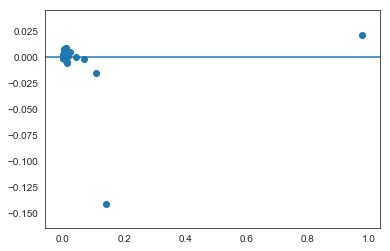

In [26]:
# Residual Error Plot
resid_2 = lm_2.resid
plt.axhline(y=0)
plt.scatter(lm_2.predict(), resid_2);

##### OBSERVATION: This plot is way better than what we had with the 2013 data, the data points are closer to the y=0 line. This show that the predicted values are closer to the actual.

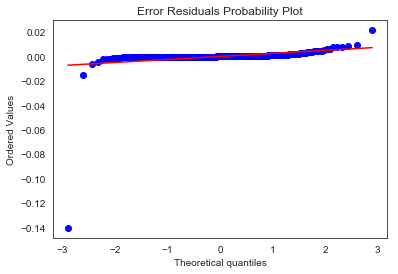

In [28]:
# Probability Plot to view normality (blue data should fit to red line of expected error)
stats.probplot(lm_2.resid, plot= plt)
plt.title("Error Residuals Probability Plot");

##### OBSERVATION: Our model fits more normally to the expected error as well

## Let's Now Evaluate Our New Linear Regression Models 
The segments that follow evalute the model we have build. Here in the evaluation we are goint to use our `statsmodel` - lm_1 rather than the scikit-learn one.

##### Let's look at the parameters of our model

In [30]:
lm_2.params

Intercept                         -0.001
arson_3                            0.001
population_square                  0.003
murder_manslaughter_categorical    0.001
robbery_categorical                0.000
cor_var_feature                    1.117
dtype: float64

**We will now examine the** `p-values` **for each** `variables` **as a test of their significance in the** `outcome`

**Calculate** $R^2$

In [32]:
lm_2.rsquared

0.9789262858224401

In [31]:
lm_2.pvalues

Intercept                         0.431
arson_3                           0.873
population_square                 0.341
murder_manslaughter_categorical   0.786
robbery_categorical               0.854
cor_var_feature                   0.000
dtype: float64

##### OBSERVATION: loking at this p-values, the only parameter that seems to explain any variance is the `cor_var_feature`. Others have p-values above 0.05 which shows that they have no significance in explaining the variance in the oucome and can all be dropped with no significant effect on the odel's performance. Let's drop these parameters and run the model again.

In [33]:
#run model with new data using statsmodel and generate summary
lm_2_1 = smf.ols(formula = "property_crime ~ cor_var_feature", data = crime_data_2014).fit()
               
#generate model's summary
lm_2_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         property_crime   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                 1.684e+04
Date:                Mon, 31 Dec 2018   Prob (F-statistic):          7.33e-307
Time:                        23:13:15   Log-Likelihood:                 1264.5
No. Observations:                 366   AIC:                            -2525.
Df Residuals:                     364   BIC:                            -2517.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0004      0.000      1.068      0.286      -0.000       0.001
cor_var_feature     1.1181      0.009    129.766      0.000       1.101       1.135
==============================================================================
Omnibus:                      819.065   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1459748.643
Skew:                         -16.837   Prob(JB):                         0.00
Kurtosis:                     310.550   Cond. No.                         21.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

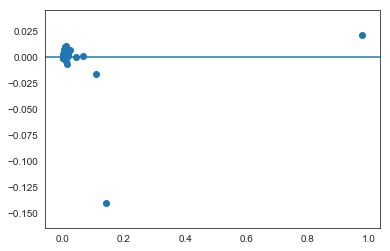

In [35]:
# Residual Error Plot
resid_2_1 = lm_2_1.resid
plt.axhline(y=0)
plt.scatter(lm_2_1.predict(), resid_2_1);

##### OBSERVATION: As can be seen from the residual error plot and rsquared value, we can significantly simplify our model(by using only one parameter: cor_var_features as our parameter) without significant drop in performance.

##### CONCLUSION: 
The original model used the 2013 crime parameter, some level of improvents were observed when the model was evaluated using Hold out and cross validation - this was done by re-runing the model with scikit-learn. Further iteration was done by running the model with a new set of data(crime_data_2014). This led to a very signifance improvement in the model with `rsquared` droping from `0.999` to `0.975`. It was then observed that with the new data almost 100% of the outcome variance was explained by only one parameter(cor_var_feature, which was actually a feature). We then dropped all other parameter and used only `cor_var_feature`, this significantly improved the model's simplicity with just sligth drop in performance. 

To further evaluate this model in the future, data from other cities aside from NYC could be used with different level of hold out and cross validation levels.